<a href="https://colab.research.google.com/github/SKamara84/Weather_info/blob/main/ARIMA2Daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Loading and Preprocessing:
- Load the data and resample it to monthly totals.
- Plot the data to visualize the time series.
- Check for stationarity using the Augmented Dickey-Fuller test.
- If the p-value is greater than 0.05, the series is non-stationary and differencing should be applied (d=1 or d=2)

In [59]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

!pip install pmdarima
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [93]:
# Load data
# df = pd.read_csv("sl_rain_81_85.csv", parse_dates=["time_start"], index_col="time_start")

# Resample to monthly totals
# monthly_data = df.resample('ME').sum()


# Load long time data
# and make sure 'Date' column is correctly parsed as datetime objects.
df = pd.read_csv("/content/DailRainfall_81_24.csv", parse_dates=["time_start"], index_col="time_start")


# Select the date range (inclusive)
start_date = '1981-01-01'
end_date = '1985-12-31'
df = df.loc[start_date:end_date]

from google.colab import data_table
data_table.enable_dataframe_formatter()

print(df)

# Resample to monthly totals
monthly_data = df.resample('ME').sum()



            precipitation
time_start               
1981-01-01          0.000
1981-01-02          0.000
1981-01-03          0.000
1981-01-04          0.168
1981-01-05          0.230
...                   ...
1985-12-27          0.000
1985-12-28          0.231
1985-12-29          0.000
1985-12-30          0.000
1985-12-31          0.000

[1826 rows x 1 columns]


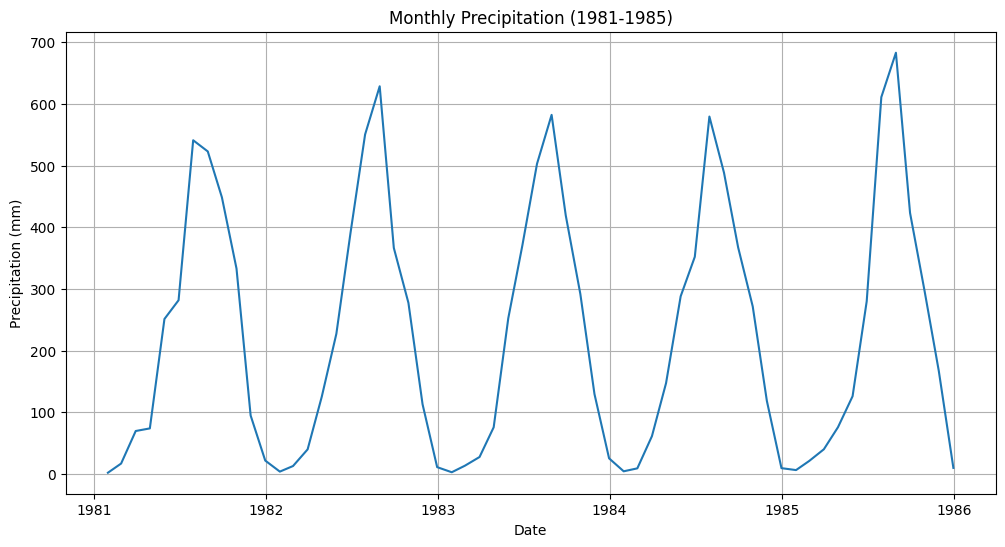

In [94]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(monthly_data)
plt.title("Monthly Precipitation (1981-1985)")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.grid()
plt.show()

In [95]:
# Augmented Dickey-Fuller test for stationarity
result = adfuller(monthly_data["precipitation"]) # Replace 'your_column' with your actual column name
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

if result[1] > 0.05:
  print("The time series is likely non-stationary. Consider differencing.")
else:
  print("The time series is likely stationary.")

ADF Statistic: -2.292690310418092
p-value: 0.17433633102091084
Critical Values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
The time series is likely non-stationary. Consider differencing.


# 2. Parameter Determination:
- Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to help identify the non-seasonal (p, d, q) parameters.
- Assume a yearly seasonality (m=12) and check for spikes at lag 12 in ACF/PACF to identify the seasonal (P, D, Q) parameters.
- Instead of manual selection, use auto_arima to automate parameter selection. This helps reduce overfitting.

In [96]:

from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

from google.colab import data_table
data_table.enable_dataframe_formatter()

# Auto-tune SARIMA parameters
model_auto = auto_arima(
    monthly_data['precipitation'],
    seasonal=True,
    m=12, # Yearly seasonality
    stepwise=True,
    trace=True,
    suppress_warnings=True,
    error_action="ignore"
)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=528.667, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=520.143, Time=0.21 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=526.710, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=528.163, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=513.200, Time=0.77 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=513.580, Time=1.35 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=513.320, Time=2.10 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=514.630, Time=2.43 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=513.098, Time=0.82 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=520.123, Time=0.29 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=513.31

3. Model Fitting:
- Extract the best parameters from auto_arima.
- Fit the SARIMA model using the optimized parameters.

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Extract best parameters from auto_arima
order = model_auto.order
seasonal_order = model_auto.seasonal_order

# Refit SARIMA with 95% CI
model = SARIMAX(
    monthly_data['precipitation'],
    order=order,
    seasonal_order=seasonal_order
)

results = model.fit(disp=False)

# 4. Residual Validation:
- After refitting the model, ensure that the residuals resemble white noise. Check for no autocorrelation in ACF/PACF of residuals, and also validate with the Ljung-Box test (p-value > 0.05).
- If residuals show patterns, increase differencing or adjust p/q values.
- The provided sources do not include code for the Ljung-Box test, but this is an important validation step that could be added.

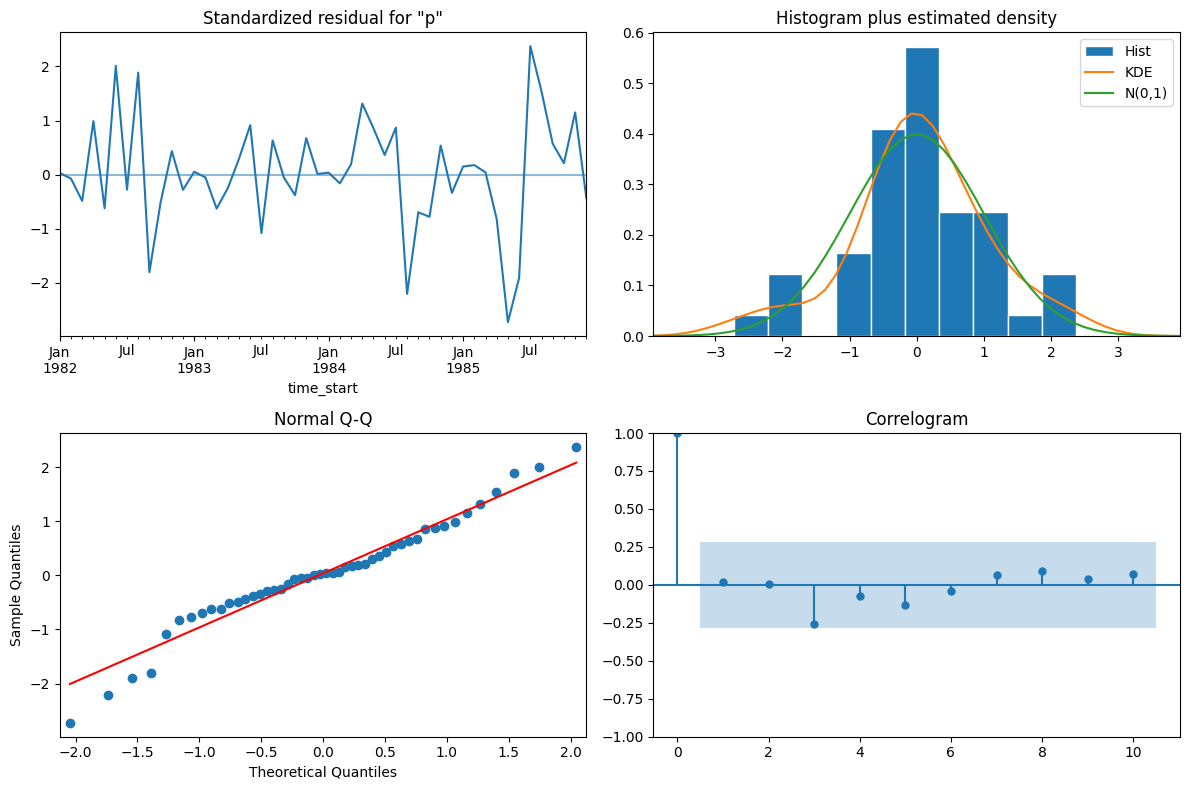

In [98]:
# Residual diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

# 5. Forecasting:
- Generate a forecast for the next 6 months, setting the alpha parameter to 0.05 to obtain a 95% confidence interval.
- Plot the observed data, the forecast, and the confidence interval.
- Display the forecast values with their 95% confidence intervals.

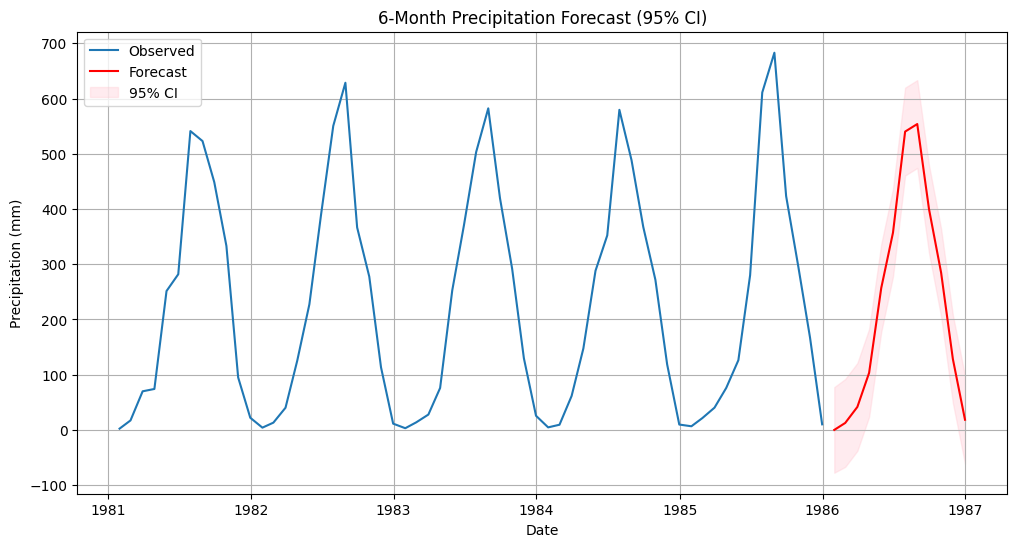


6-Month Forecast (95% CI):
1986-01-31     -0.17
1986-02-28     12.48
1986-03-31     41.46
1986-04-30    103.19
1986-05-31    256.83
1986-06-30    357.06
1986-07-31    540.10
1986-08-31    553.79
1986-09-30    399.80
1986-10-31    284.43
1986-11-30    128.19
1986-12-31     18.24
Freq: ME, Name: predicted_mean, dtype: float64
            lower precipitation  upper precipitation
1986-01-31           -77.684611            77.349359
1986-02-28           -67.069783            92.021512
1986-03-31           -38.081815           121.009481
1986-04-30            23.641806           182.733101
1986-05-31           177.281583           336.372879
1986-06-30           277.515823           436.607119
1986-07-31           460.553824           619.645120
1986-08-31           474.244362           633.335657
1986-09-30           320.254388           479.345684
1986-10-31           204.884855           363.976150
1986-11-30            48.649074           207.740369
1986-12-31           -61.300922      

In [101]:
# Forecast with explicit 95% confidence level
forecast = results.get_forecast(steps=12, alpha=0.05) # 95% CI
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot with 95% CI
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['precipitation'], label='Observed')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
plt.fill_between(
    confidence_intervals.index,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='95% CI'
)
plt.title("6-Month Precipitation Forecast (95% CI)")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.legend()
plt.grid()
plt.show()

# Display forecast values
print("\n6-Month Forecast (95% CI):")
print(forecast_mean.round(2))
print(confidence_intervals)